In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch torchvision transformers seaborn matplolib tqdm tensorboard


ERROR: Could not find a version that satisfies the requirement matplolib (from versions: none)
ERROR: No matching distribution found for matplolib


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from typing import Tuple
import random
from PIL import Image
from transformers import DeiTForImageClassification, DeiTFeatureExtractor
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import ConvNextForImageClassification,  ConvNextFeatureExtractor
import matplotlib.pyplot as plt

In [ ]:
# Initalize ConvNeXt model with imagenet weights

num_classes = 3

model = ConvNextForImageClassification.from_pretrained('facebook/convnext-tiny-224', num_labels=num_classes, ignore_mismatched_sizes=True)
feature_extractor = ConvNextFeatureExtractor.from_pretrained('facebook/convnext-tiny-224')

model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/114M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [ ]:
# Data loader class that applies data augmentation, change to grayscale and normalize all images in the dataset 1
class CovidDataloader:
    def __init__(self):
        dataset = "Pre_Train"
        self.train_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Train"
        self.val_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Val"
        self.test_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Test"

        def grayscale_to_rgb(image):
            return Image.merge('RGB', (image, image, image))

        self.train_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((224, 224)),
            transforms.Lambda(grayscale_to_rgb),  # USe grayscale values for all 3 channels for train set images

            # Apply data augmentation Random Horizontal and Vetrical Filp, Rotation by 15 degress, translation, scale, shear and normalize the images only in train set
            transforms.RandomApply([
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
                transforms.RandomAffine(degrees=0, shear=10)
            ], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.val_test_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((224, 224)),
            transforms.Lambda(grayscale_to_rgb),  # Use grayscale values for all 3 channels for test and validation sets
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.train_dataset = datasets.ImageFolder(root=self.train_dir, transform=self.train_transform)
        self.val_dataset = datasets.ImageFolder(root=self.val_dir, transform=self.val_test_transform)
        self.test_dataset = datasets.ImageFolder(root=self.test_dir, transform=self.val_test_transform)

    def get_loaders(self, batch_size: int = 32, num_workers: int = 2):
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

        return train_loader, val_loader, test_loader



dataloader = CovidDataloader()
train_loader, val_loader, test_loader = dataloader.get_loaders(batch_size=64)

print(f"Length of training dataset: {len(dataloader.train_dataset)}")
print(f"Length of validation dataset: {len(dataloader.val_dataset)}")
print(f"Length of test dataset: {len(dataloader.test_dataset)}")


Length of training dataset: 3840
Length of validation dataset: 956
Length of test dataset: 1199


In [ ]:

# Use the learning rate and weight decay used by the model for its imagenet fine-tuning

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)


writer = SummaryWriter()

num_epochs = 10

#  Train model for 10 epochs on training set and validation set

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch}/{num_epochs - 1}")
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.max(outputs.logits, 1)[1]
        running_corrects += torch.sum(preds == labels.data)


    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = torch.max(outputs.logits, 1)[1]
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)

    writer.add_scalars('Loss', {'train': epoch_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': epoch_acc, 'val': val_acc}, epoch)

    print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

writer.close()

Starting epoch 0/9


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0/9, Train Loss: 0.4660, Train Acc: 0.8091, Val Loss: 0.3005, Val Acc: 0.8326
Starting epoch 1/9
Epoch 1/9, Train Loss: 0.3372, Train Acc: 0.8714, Val Loss: 0.1983, Val Acc: 0.8567
Starting epoch 2/9
Epoch 2/9, Train Loss: 0.2638, Train Acc: 0.9005, Val Loss: 0.1905, Val Acc: 0.8713
Starting epoch 3/9
Epoch 3/9, Train Loss: 0.2495, Train Acc: 0.9029, Val Loss: 0.1573, Val Acc: 0.8808
Starting epoch 4/9
Epoch 4/9, Train Loss: 0.2094, Train Acc: 0.9187, Val Loss: 0.1837, Val Acc: 0.8619
Starting epoch 5/9
Epoch 5/9, Train Loss: 0.1775, Train Acc: 0.9362, Val Loss: 0.2074, Val Acc: 0.8619
Starting epoch 6/9
Epoch 6/9, Train Loss: 0.1671, Train Acc: 0.9362, Val Loss: 0.1997, Val Acc: 0.8661
Starting epoch 7/9
Epoch 7/9, Train Loss: 0.1898, Train Acc: 0.9260, Val Loss: 0.2011, Val Acc: 0.8692
Starting epoch 8/9
Epoch 8/9, Train Loss: 0.1414, Train Acc: 0.9461, Val Loss: 0.1932, Val Acc: 0.8588
Starting epoch 9/9
Epoch 9/9, Train Loss: 0.1200, Train Acc: 0.9594, Val Loss: 0.2329, Val A

In [ ]:
# Test the model

model.eval()

true_labels = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())


true_labels = np.array(true_labels)
predictions = np.array(predictions)

classification_rep = classification_report(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
test_acc = accuracy_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

In [ ]:

print("Classification Report:\n", classification_rep)
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(test_acc))
print("Confusion Matrix:\n", conf_matrix)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       423
           1       0.87      0.97      0.92       398
           2       0.98      0.83      0.90       331

    accuracy                           0.93      1152
   macro avg       0.94      0.93      0.93      1152
weighted avg       0.94      0.93      0.93      1152

F1 Score: 0.9326
Test Accuracy: 0.9332
Confusion Matrix:
 [[415   5   3]
 [  9 385   4]
 [  4  52 275]]


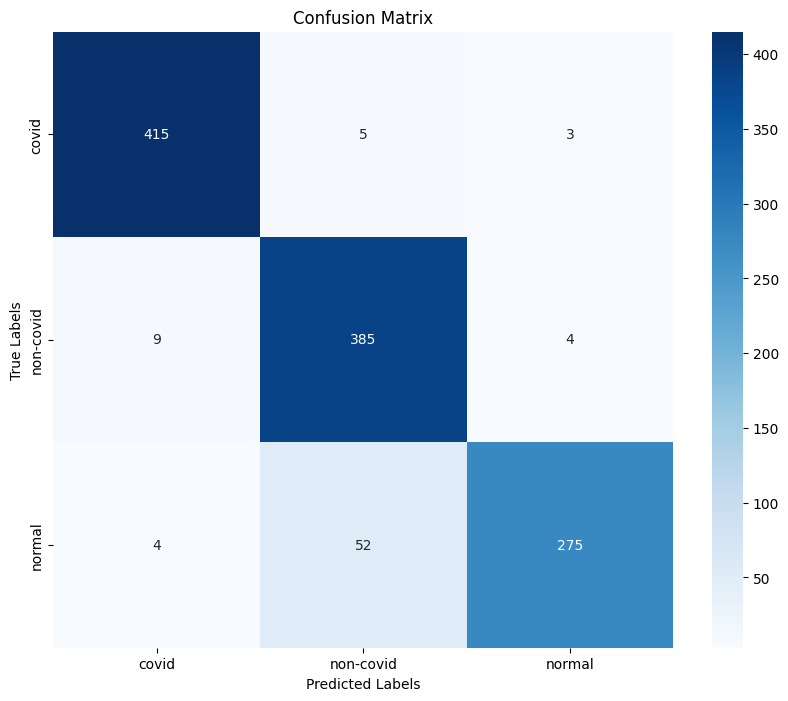

In [ ]:
class_names = ['covid', 'non-covid', 'normal']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/runs/backbone/convnext/model.pth')

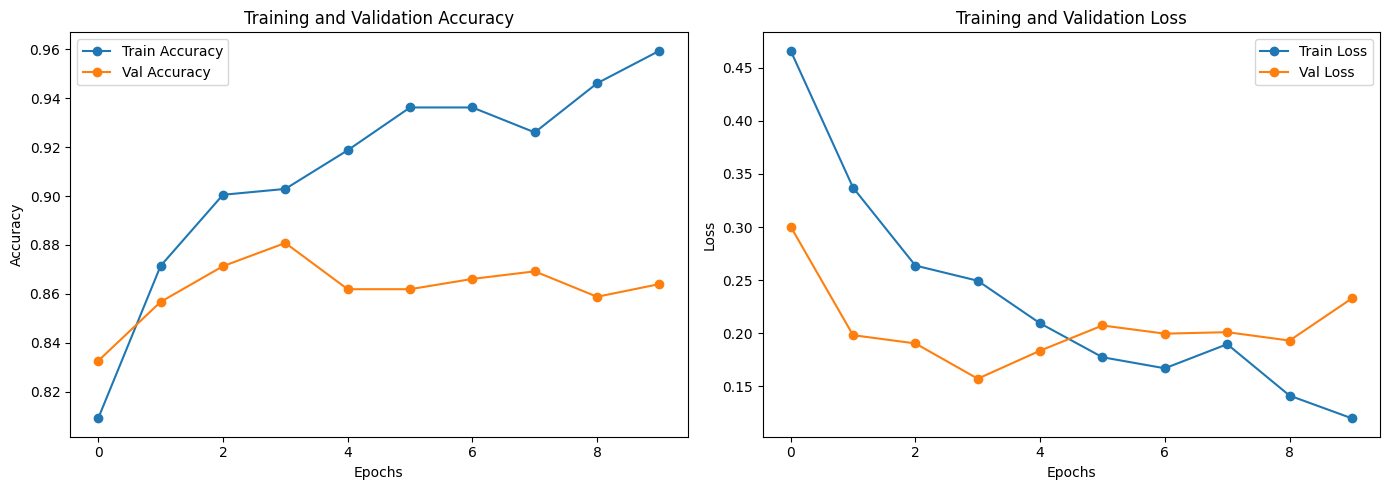

In [ ]:
# Plot the training and validation loss and accuracy graphs

epochs = list(range(10))
train_loss = [0.4660, 0.3372, 0.2638, 0.2495, 0.2094, 0.1775, 0.1671, 0.1898, 0.1414, 0.1200]
train_acc = [0.8091, 0.8714, 0.9005, 0.9029, 0.9187, 0.9362, 0.9362, 0.9260, 0.9461, 0.9594]
val_loss = [0.3005, 0.1983, 0.1905, 0.1573, 0.1837, 0.2074, 0.1997, 0.2011, 0.1932, 0.2329]
val_acc = [0.8326, 0.8567, 0.8713, 0.8808, 0.8619, 0.8619, 0.8661, 0.8692, 0.8588, 0.8640]

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Funtion to visualise GRAD-CAM

def grad_cam(model, input_image, target_layer):
    model.eval()

    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    forward_hook_handle = target_layer.register_forward_hook(forward_hook)
    backward_hook_handle = target_layer.register_backward_hook(backward_hook)

    output = model(input_image).logits

    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    class_loss = output[0, pred_class]
    class_loss.backward()

    gradient = gradients[0].cpu().data.numpy()
    activation = activations[0].cpu().data.numpy()

    weights = np.mean(gradient, axis=(2, 3))

    cam = np.zeros(activation.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights[0]):
        cam += w * activation[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    if np.max(cam) != 0:
        cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    cam = Image.fromarray(cam)
    cam = cam.resize((input_image.shape[2], input_image.shape[3]), Image.ANTIALIAS)

    forward_hook_handle.remove()
    backward_hook_handle.remove()

    return cam

Loaded image: /content/drive/MyDrive/new_dataset/Dataset/Test/COVID-19/images/sub-S09425_ses-E21769_run-1_bp-chest_vp-ap_dx.png from class COVID-19
Loaded image: /content/drive/MyDrive/new_dataset/Dataset/Test/COVID-19/images/sub-S09424_ses-E25330_run-1_bp-chest_vp-pa_dx.png from class COVID-19
Loaded image: /content/drive/MyDrive/new_dataset/Dataset/Test/COVID-19/images/sub-S09426_ses-E17865_run-1_bp-chest_vp-ap_dx.png from class COVID-19
Loaded image: /content/drive/MyDrive/new_dataset/Dataset/Test/Non-COVID/images/non_COVID (3783).png from class Non-COVID
Loaded image: /content/drive/MyDrive/new_dataset/Dataset/Test/Non-COVID/images/non_COVID (3768).png from class Non-COVID
Loaded image: /content/drive/MyDrive/new_dataset/Dataset/Test/Non-COVID/images/non_COVID (3807).png from class Non-COVID
Loaded image: /content/drive/MyDrive/new_dataset/Dataset/Test/Normal/images/Normal (8801).png from class Normal
Loaded image: /content/drive/MyDrive/new_dataset/Dataset/Test/Normal/images/Norma

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
<ipython-input-17-59319e841b62>:44: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cam = cam.resize((input_image.shape[2], input_image.shape[3]), Image.ANTIALIAS)


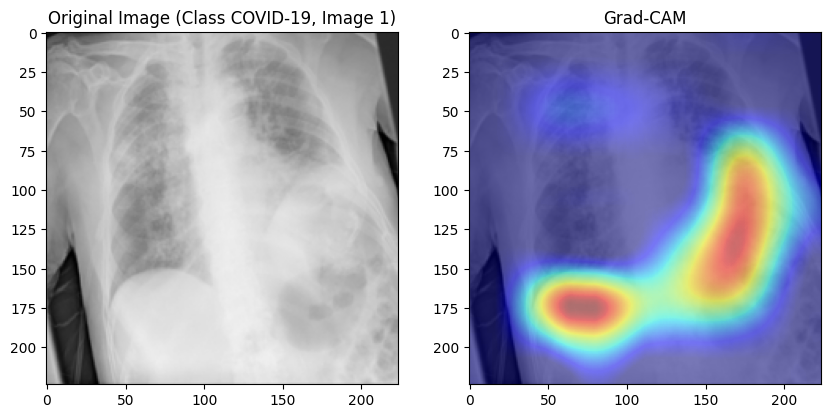

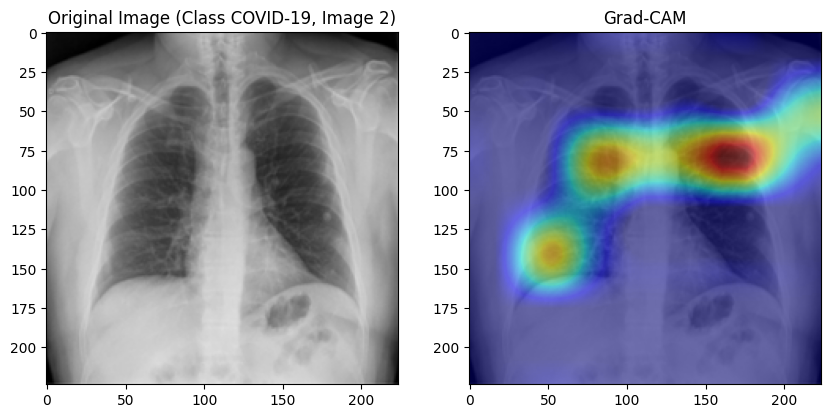

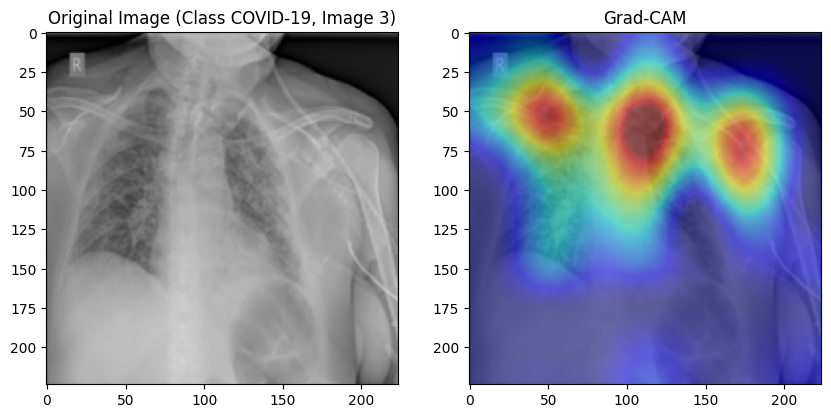

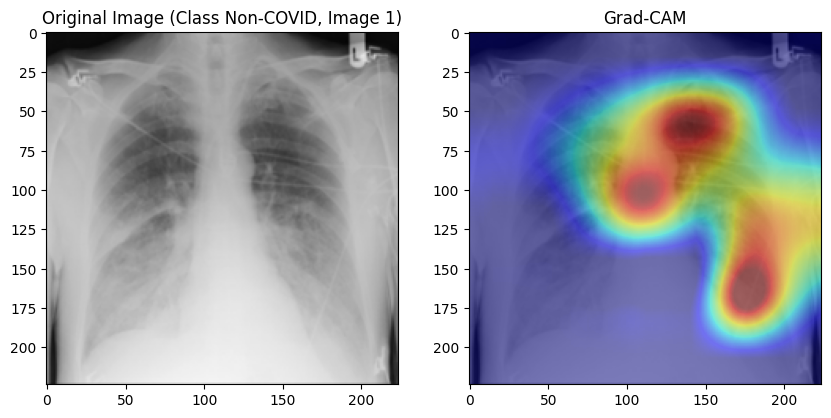

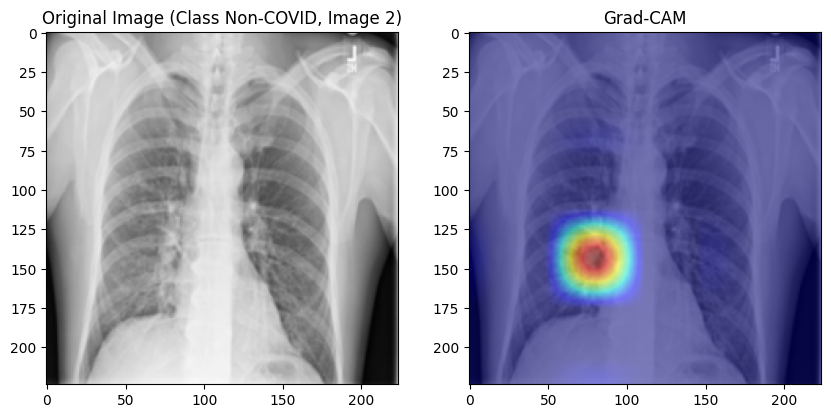

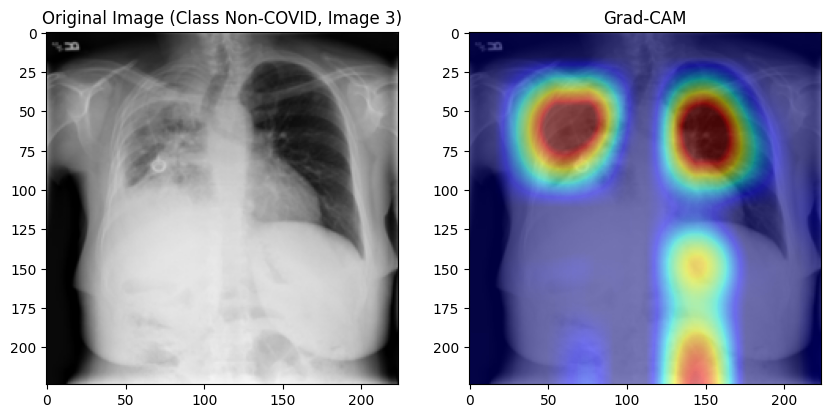

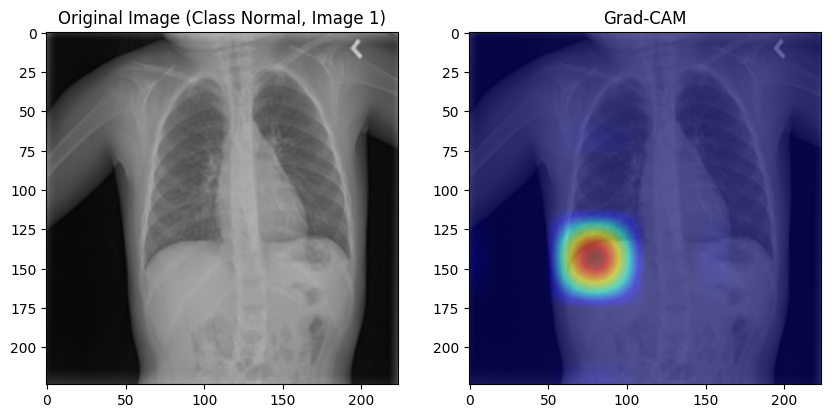

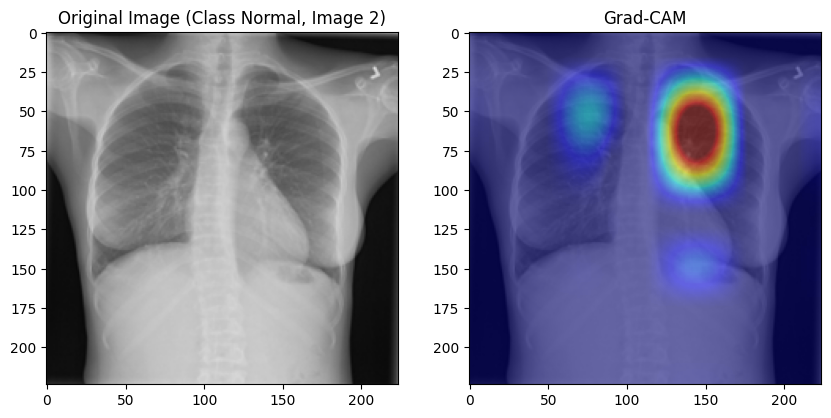

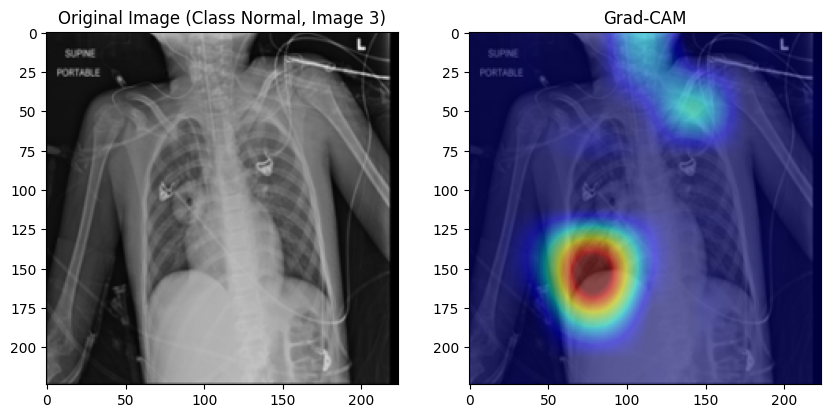

In [ ]:
test_dir = "/content/drive/MyDrive/new_dataset/Dataset/Test"
subfolders = ['COVID-19', 'Non-COVID', 'Normal']

# Set the size of the images to 224 x 224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load three images from each class in the test set
selected_images = {}
for i, subfolder in enumerate(subfolders):
    subfolder_path = os.path.join(test_dir, subfolder, 'images')
    image_files = os.listdir(subfolder_path)[:3]

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(subfolder_path, image_file)

        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0)
        selected_images[(i, j)] = image_tensor

        print(f"Loaded image: {image_path} from class {subfolder}")

target_layer = model.convnext.encoder.stages[-1].layers[-1].dwconv  # Last ConvNextLayer's dwconv in the last stage


# Visualize Grad-CAM
for (label, idx), input_image in selected_images.items():
    cam = grad_cam(model, input_image=input_image.to('cuda'), target_layer=target_layer)

    if cam:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.title(f'Original Image (Class {subfolders[label]}, Image {idx+1})')

        plt.subplot(1, 2, 2)
        plt.imshow(input_image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title('Grad-CAM')
        plt.show()
    else:
        print(f"No valid CAM for class {subfolders[label]} Image {idx+1}. Skipping visualization.")
